In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Examples in the reference link

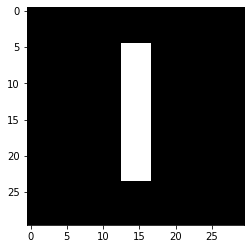

In [2]:
# Create a simple rectangular image
f = np.zeros((30, 30))
f[5:24,13:17] = 1
_ = plt.imshow(f, cmap='gray')

In [3]:
# DFT of f and the output has the same shape as the input
F = np.fft.fft2(f)
F.shape

(30, 30)

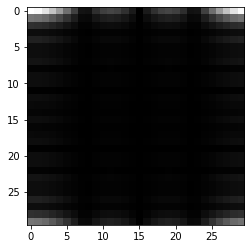

In [4]:
# Magnitude spectrum
magnitude = np.abs(F)
_ = plt.imshow(magnitude, cmap='gray')

In [5]:
# DFT of f but the input is padded
F2 = np.fft.fft2(f, (256, 256))
F2.shape

(256, 256)

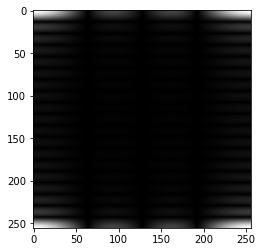

In [6]:
magnitude2 = np.abs(F2)
_ = plt.imshow(magnitude2, cmap='gray')

In [7]:
# Center the zero frequency
F2_shift = np.fft.fftshift(F2)

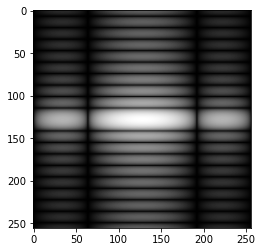

In [8]:
magnitude_log = np.log(1 + np.abs(F2_shift))
_ = plt.imshow(magnitude_log, cmap='gray')

# 2. Create filters in frequency domain from spatial domain

(500, 500)

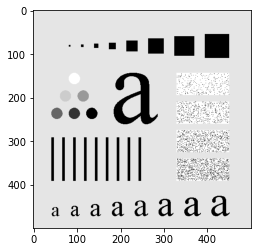

In [9]:
img = cv2.imread('letter_A.tif', 0)
_ = plt.imshow(img, cmap='gray')
img.shape

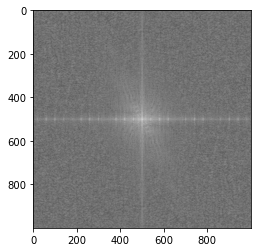

In [10]:
# Frequency spectrum of the image
fft_img = np.fft.fft2(img, (1000, 1000)) # padding the input image
fft_img_shift = np.fft.fftshift(fft_img)
magnitude_log1 = np.log(1 + np.abs(fft_img_shift))
_ = plt.imshow(magnitude_log1, cmap='gray')

In [11]:
# Convert spatial filters to frequency filters

# gaussian
x = cv2.getGaussianKernel(10,10)
gaussian = x*x.T
# sobel in x direction
sobel_x = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# sobel in y direction
sobel_y = np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])
# laplacian
laplacian = np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

filters = [gaussian, laplacian, sobel_x, sobel_y]
filter_name = ['gaussian', 'laplacian', 'sobel_x', 'sobel_y']
fft_filters = [np.fft.fft2(x, (1000, 1000)) for x in filters] 
fft_filters_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_filters_shift]

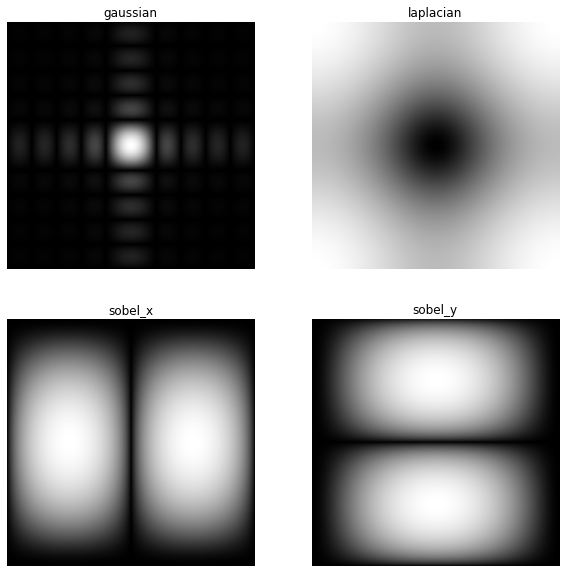

In [12]:
# Frequency spectrums of defined filters
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(mag_spectrum[i], cmap='gray')
    plt.title(filter_name[i])
    plt.axis('off')

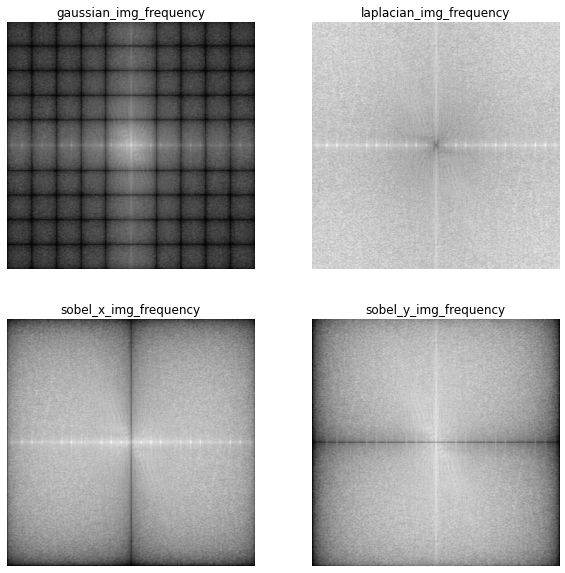

In [13]:
# Multiply the image and the filters in frequency domain
plt.figure(figsize=(10, 10))
filtered_img = [np.multiply(x, fft_img_shift) for x in fft_filters_shift]
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(np.log(np.abs(filtered_img[i])+1), cmap='gray')
    plt.title(filter_name[i] + '_img_frequency')
    plt.axis('off')

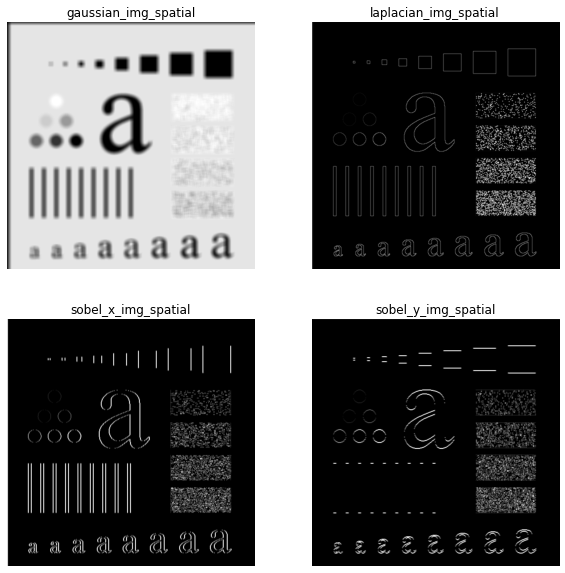

In [14]:
# Change back to the spatial domain
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    filtered_img_ishift = np.fft.ifftshift(filtered_img[i])
    img_back = np.fft.ifft2(filtered_img_ishift)[:500, :500]
    _ = plt.imshow(np.abs(img_back), cmap='gray')
    plt.title(filter_name[i] + '_img_spatial')
    plt.axis('off')

# 3. Create filters directly in frequency domain

## 3.1 Low Pass Filters

In [15]:
class LowPassFilter:
    def __init__(self, img, D0):
        self.img = img
        M, N = img.shape
        mesh_indices = np.indices((M, N))
        self.D = np.sqrt((np.square(mesh_indices[0] - M/2) + np.square(mesh_indices[1] - N/2)))
        self.D0 = D0
    def Ideal(self):
        H = np.float32(self.D <= self.D0)
        img_filtered = H * self.img
        return H, img_filtered
    def Gaussian(self):
        H = np.exp(-np.square(self.D) / (2*self.D0**2))
        img_filtered = H * self.img
        return H, img_filtered
    def Butterworth(self, n=1):
        H = 1/(1 + (self.D/self.D0)**(2*n))
        img_filtered = H * self.img
        return H, img_filtered

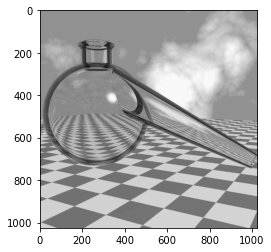

In [16]:
img_tube = cv2.imread('tube.tif', 0)
M, N = img_tube.shape
_ = plt.imshow(img_tube, cmap='gray')

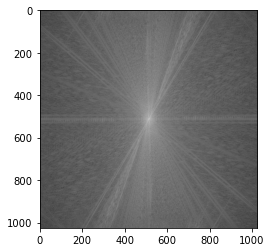

In [17]:
# Fourier spectrum of the image
fft_img_tube = np.fft.fft2(img_tube) 
fft_img_tube_shift = np.fft.fftshift(fft_img_tube)
magni_log = np.log(1 + np.abs(fft_img_tube_shift))
_ = plt.imshow(magni_log, cmap='gray')

In [18]:
D0 = 0.03*M
LowPass = LowPassFilter(fft_img_tube_shift, D0=D0)

In [19]:
H_ideal, tube_filtered_ideal = LowPass.Ideal()
H_gaussian, tube_filtered_gaussian = LowPass.Gaussian()
H_butterworth, tube_filtered_butterworth = LowPass.Butterworth(n=3)

In [20]:
H = [H_ideal, H_gaussian, H_butterworth]
H_name = ['Ideal Lowpass filter', 'Gaussian Lowpass filter', 'Butterworth Lowpass filter']
tube_filtered = [tube_filtered_ideal, tube_filtered_gaussian, tube_filtered_butterworth]
tube_filtered_name = ['Tube_FT_Ideal', 'Tube_FT_Gaussian', 'Tube_FT_Butterworth']

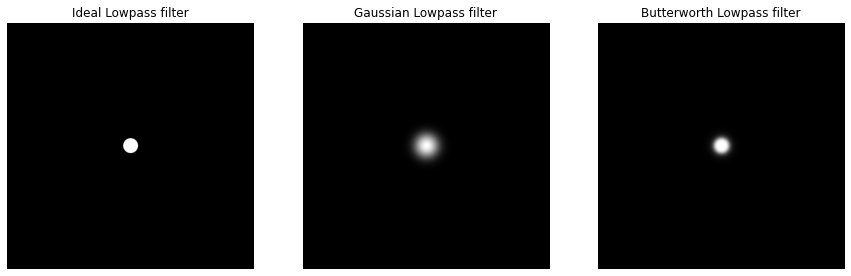

In [21]:
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    _ = plt.imshow(np.log(1+np.abs(H[i])), cmap='gray')
    plt.title(H_name[i])
    plt.axis('off')

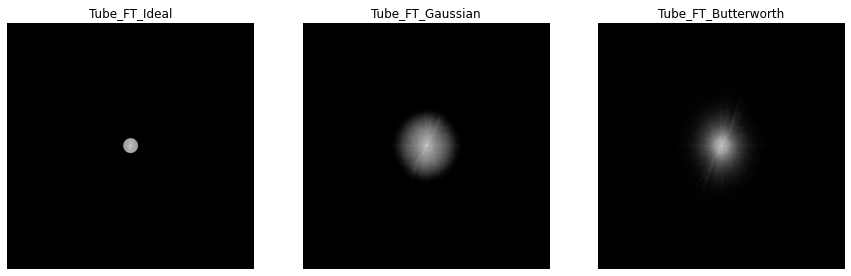

In [22]:
# Image in frequency domain
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    _ = plt.imshow(np.log(1+np.abs(tube_filtered[i])), cmap='gray')
    plt.title(tube_filtered_name[i])
    plt.axis('off')

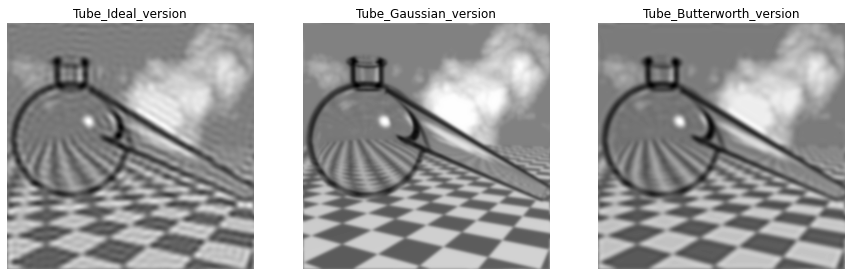

In [23]:
# Convert to the spatial domain
plt.figure(figsize=(15, 5))
tube = []
tube_name = ['Tube_Ideal_version','Tube_Gaussian_version', 'Tube_Butterworth_version']
for i in range(3):
    plt.subplot(1, 3, i+1)
    tube_ishift = np.fft.ifftshift(tube_filtered[i])
    tube_back = np.fft.ifft2(tube_ishift)
    tube.append(tube_back)
    _ = plt.imshow(np.abs(tube_back), cmap='gray')
    plt.title(tube_name[i])
    plt.axis('off')

## 3.2 High Pass Filters

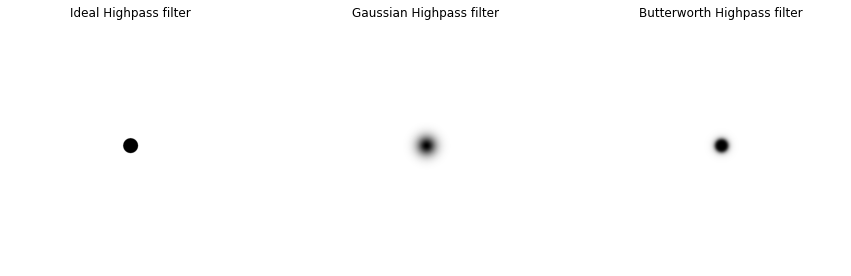

In [24]:
# H high pass = 1 - H low pass
H_high = [1 - H_ideal, 1 -  H_gaussian, 1 - H_butterworth]
H_high_name = ['Ideal Highpass filter', 'Gaussian Highpass filter', 'Butterworth Highpass filter']
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    _ = plt.imshow(np.log(1+np.abs(H_high[i])), cmap='gray')
    plt.title(H_high_name[i])
    plt.axis('off')

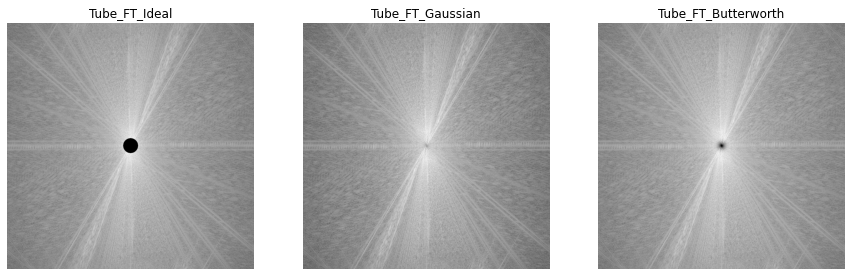

In [25]:
plt.figure(figsize=(15, 5))
tube_high_filtered = []
for i in range(3):
    plt.subplot(1, 3, i+1)
    tube_filtered = H_high[i] * fft_img_tube_shift
    _ = plt.imshow(np.log(1+np.abs(tube_filtered)), cmap='gray')
    tube_high_filtered.append(tube_filtered)
    plt.title(tube_filtered_name[i])
    plt.axis('off')

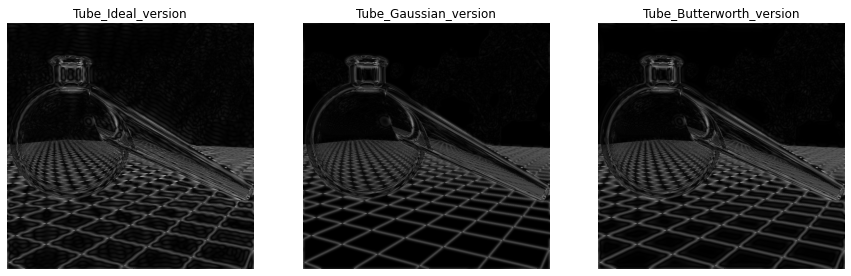

In [26]:
# Convert to the spatial domain
plt.figure(figsize=(15, 5))
tube = []
tube_name = ['Tube_Ideal_version','Tube_Gaussian_version', 'Tube_Butterworth_version']
for i in range(3):
    plt.subplot(1, 3, i+1)
    tube_ishift = np.fft.ifftshift(tube_high_filtered[i])
    tube_back = np.fft.ifft2(tube_ishift)
    tube.append(tube_back)
    _ = plt.imshow(np.abs(tube_back), cmap='gray')
    plt.title(tube_name[i])
    plt.axis('off')

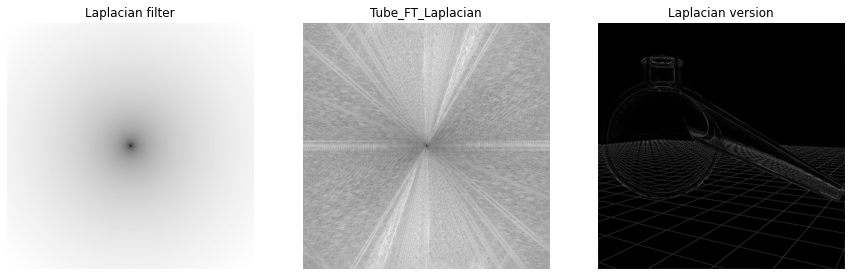

In [27]:
# Laplacian filter
plt.figure(figsize=(15, 5))
mesh_indices = np.indices((M, N))
D_square = np.square(mesh_indices[0] - M/2) + np.square(mesh_indices[1] - N/2)
H_laplacian = -4 * (np.pi)**2 * D_square
tube_laplacian = H_laplacian * fft_img_tube_shift
plt.subplot(1, 3, 1)
_ = plt.imshow(np.log(1+np.abs(H_laplacian)), cmap='gray')
plt.title("Laplacian filter")
plt.axis('off')
plt.subplot(1, 3, 2)
_ = plt.imshow(np.log(1+np.abs(tube_laplacian)), cmap='gray')
plt.title("Tube_FT_Laplacian")
plt.axis('off')
tube_L_ishift = np.fft.ifftshift(tube_laplacian)
tube_L_back = np.fft.ifft2(tube_L_ishift)
plt.subplot(1, 3, 3)
_ = plt.imshow(np.abs(tube_L_back), cmap='gray')
plt.title("Laplacian version")
plt.axis('off');